## Imports

In [1]:
import os
import h5py
import numpy as np
from scipy.signal import butter, filtfilt

import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Conv1D, LSTM, Dropout, BatchNormalization, Dense, GlobalAveragePooling1D
from keras.optimizers import Nadam
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

## Constants

In [2]:
DOWNSAMPLING_STEP = 2
NUM_CLASSES = 4
N_BATCHES = 10

ENCODE_MAP = {
        'rest': 0,
        'motor': 1,
        'memory': 2,
        'math': 3,
    }

## Load data

In [3]:
def get_dataset_name(filename_with_dir):
    filename_without_dir = filename_with_dir.split('/')[-1]
    temp = filename_without_dir.split('_')[:-1]
    dataset_name = '_'.join(temp)
    return dataset_name

def extract_label(filename, logs=False, encode_mapping=ENCODE_MAP):
    if 'rest' in filename:
        print(f'Mapping label {filename} to {encode_mapping["rest"]}') if logs else None
        return encode_mapping['rest']
    elif 'motor' in filename:
        print(f'Mapping label {filename} to {encode_mapping["motor"]}') if logs else None
        return encode_mapping['motor']
    elif 'memory' in filename:
        print(f'Mapping label {filename} to {encode_mapping["memory"]}') if logs else None
        return encode_mapping['memory']
    else:
        print(f'Mapping label {filename} to {encode_mapping["math"]}') if logs else None
        return encode_mapping['math']

def load_all_data(folder_path, logs=False):
    X = []
    y = []

    for filename in os.listdir(folder_path):
        if filename.endswith('.h5'):
            print(f"Loading {filename}...") if logs else None
            file_path = os.path.join(folder_path, filename)
            with h5py.File(file_path, 'r') as f:
                dataset_name = get_dataset_name(file_path)
                data = f.get(dataset_name)[()]
                label = extract_label(filename)
                print(f"Data shape: {data.shape}, label: {label}") if logs else None
                X.append(data)       # shape (248, 35624)
                y.append(label)      # 'motor', 'rest', etc.
    X = np.array(X)  # shape (n_samples, 248, 35624)
    y = np.array(y)  # shape (n_samples,)
    return X, y

## ETA

In [13]:
def plot_eeg_sample(X, channel_idx=0, sample_idx=0):
    """
    Plots a single EEG channel from a given sample.

    Args:
        X: EEG data array of shape (n_samples, 248, T)
        channel_idx: Index of the EEG channel (0–247)
        sample_idx: Index of the sample to visualize
    """
    signal = X[sample_idx, channel_idx]
    plt.figure(figsize=(12, 4))
    plt.plot(signal)
    plt.title(f"Sample {sample_idx} - Channel {channel_idx}")
    plt.xlabel("Time")
    plt.ylabel("Amplitude (µV)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

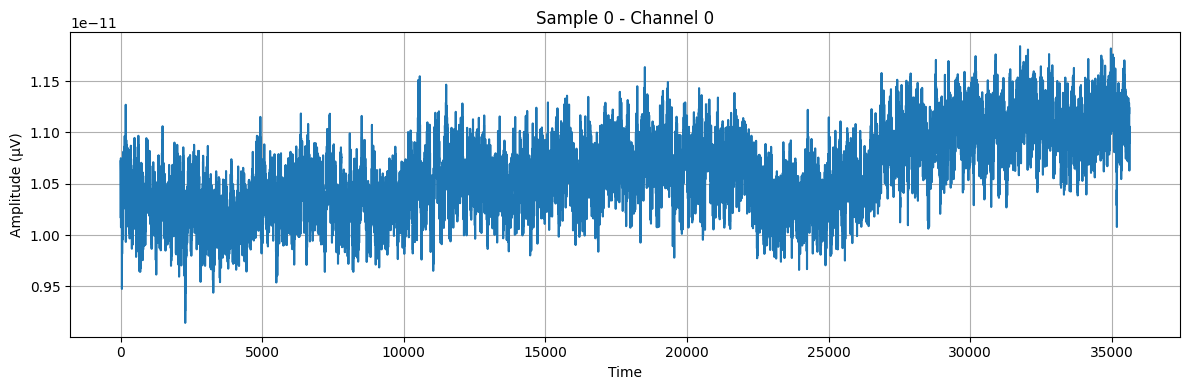

In [14]:
X_raw, y_raw = load_all_data("Intra/train")
plot_eeg_sample(X_raw, channel_idx=0, sample_idx=0)

## Preprocessing

In [48]:
def z_score_normalize(data):
    # data: shape (248, T)
    mean = np.mean(data, axis=1, keepdims=True)
    std = np.std(data, axis=1, keepdims=True) + 1e-8
    return (data - mean) / std


def butter_bandpass(lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def apply_bandpass_filter(data, lowcut=1, highcut=40, fs=500, order=4):
    b, a = butter_bandpass(lowcut, highcut, fs, order)
    return filtfilt(b, a, data, axis=0)


def downsample(data, step=DOWNSAMPLING_STEP):
    # data: shape (248, T)
    return np.array(data[:, ::step])  # keep every 8th column
# band pass or low pass filter before downsampling


def split_to_batches(X, y, n_batches=N_BATCHES):
    """
    Splits each sample in X into `n_batches` chunks along the time axis.
    Each resulting chunk keeps the same label as the original sample.

    Args:
        X (np.ndarray): shape (n_samples, n_channels, time_steps)
        y (np.ndarray): shape (n_samples,)
        n_batches (int): how many segments to split each sample into

    Returns:
        X_out (np.ndarray): shape (n_samples * n_batches, n_channels, time_steps // n_batches)
        y_out (np.ndarray): shape (n_samples * n_batches,)
    """
    X_out = []
    y_out = []

    for i in range(len(X)):
        sample = X[i]  # (n_channels, T)
        label = y[i]
        T = sample.shape[1]
        batch_len = T // n_batches
        usable_len = batch_len * n_batches  # discard leftover

        sample = sample[:, :usable_len]  # truncate extra
        for j in range(n_batches):
            chunk = sample[:, j * batch_len : (j + 1) * batch_len]
            X_out.append(chunk)
            y_out.append(label)

    return np.array(X_out), np.array(y_out)


In [49]:
# Specify the folder name and load the data. (Don't push data folders to GitHub!!!)
X_raw, y_raw = load_all_data("Intra/train")
X_preprocessed = [downsample(z_score_normalize(apply_bandpass_filter(x))) for x in X_raw]
X_preprocessed = np.array(X_preprocessed)

# Split to batches
X_batch, y_batch = split_to_batches(X_preprocessed, y_raw, n_batches=N_BATCHES)
print(f"X shape: {X_batch.shape}, y shape: {y_batch.shape}")  # (n_samples * N_BATCHES, 248, T/N_BATCHES) # (n_samples * N_BATCHES,)

# Transpose to match Conv1D input: (samples, timesteps, channels)
X_batch = np.transpose(X_batch, (0, 2, 1))  # shape: (n_samples, time_steps, num_channels)

# One-hot encode labels
if y_batch.ndim == 1:
    y_batch = to_categorical(y_batch, num_classes=NUM_CLASSES)

X shape: (320, 248, 1781), y shape: (320,)


In [50]:
X_train, X_val, y_train, y_val = train_test_split(
    X_batch, y_batch, test_size=0.2, stratify=np.argmax(y_batch, axis=1), random_state=42
)

## CNN Model only

In [51]:
time_steps = X_train.shape[1]
num_channels = X_train.shape[2]

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

cnn_model = Sequential([
    Conv1D(64, 3, activation="relu", padding="same", input_shape=(time_steps, num_channels)),
    BatchNormalization(),
    Dropout(0.2),

    Conv1D(128, 5, activation="relu", padding="same"),
    BatchNormalization(),
    Dropout(0.2),

    GlobalAveragePooling1D(),

    Dense(64, activation='relu'),
    Dropout(0.3),

    Dense(NUM_CLASSES, activation='softmax')
])

cnn_model.compile(optimizer=Nadam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [52]:
history = cnn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 404ms/step - accuracy: 0.2854 - loss: 1.3858 - val_accuracy: 0.2500 - val_loss: 1.3863
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 221ms/step - accuracy: 0.3615 - loss: 1.3677 - val_accuracy: 0.2500 - val_loss: 1.3863
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 219ms/step - accuracy: 0.3844 - loss: 1.3445 - val_accuracy: 0.2500 - val_loss: 1.3863
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 224ms/step - accuracy: 0.3734 - loss: 1.3314 - val_accuracy: 0.2500 - val_loss: 1.3864
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 219ms/step - accuracy: 0.4557 - loss: 1.2982 - val_accuracy: 0.2500 - val_loss: 1.3865
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 220ms/step - accuracy: 0.4193 - loss: 1.2654 - val_accuracy: 0.2500 - val_loss: 1.3867


## Testing and evaluating part

In [37]:
# Load and preprocess test data
X_test_raw, y_test_raw = load_all_data("Intra/test", logs=0)
print(f"X_test shape before preprocessing: {np.array(X_test_raw).shape}")

# Preprocessing
X_test_preprocessed = [downsample(z_score_normalize(apply_bandpass_filter(x))) for x in X_test_raw]
X_test_preprocessed = np.array(X_test_preprocessed)
print(f"X_test shape after preprocessing: {X_test_preprocessed.shape}")

# Split into batches
X_test_batch, y_test_batch = split_to_batches(X_test_preprocessed, y_test_raw, n_batches=N_BATCHES)
print(f"X_test_batch shape: {X_test_batch.shape}, y_test_batch shape: {y_test_batch.shape}")

# Transpose to (samples, time_steps, channels)
X_test_batch = np.transpose(X_test_batch, (0, 2, 1))  # shape: (n_samples, time_steps, num_channels)

# One-hot encode labels
y_test_batch = to_categorical(y_test_batch, num_classes=NUM_CLASSES)

X_test shape before preprocessing: (8, 248, 35624)
X_test shape after preprocessing: (8, 248, 8906)
X_test_batch shape: (800, 248, 89), y_test_batch shape: (800,)


In [53]:
import numpy as np
from scipy.stats import mode

def majority_vote(predictions, n_batches):
    """
    predictions: np.array of shape (samples * n_batches, num_classes)
    returns: np.array of shape (samples,)
    """
    # Convert to class labels
    pred_labels = np.argmax(predictions, axis=1)
    # Reshape to (samples, n_batches)
    pred_labels = pred_labels.reshape(-1, n_batches)
    # Take the mode (most frequent label) across batches
    majority_labels, _ = mode(pred_labels, axis=1, keepdims=False)
    return majority_labels

# Predict on batched test data
pred_probs = cnn_model.predict(X_test_batch)
y_pred_majority = majority_vote(pred_probs, N_BATCHES)

# True labels (one per original file)
y_true = np.argmax(y_test_batch[::N_BATCHES], axis=1)  # one per file

# Accuracy
acc = np.mean(y_pred_majority == y_true)
print("Majority vote test accuracy:", acc)


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Majority vote test accuracy: 0.25


In [45]:
# Evaluate
test_loss, test_acc = cnn_model.evaluate(X_test_batch, y_test_batch, verbose=1)
print("Test accuracy:", test_acc)

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2002 - loss: 1.3995   
Test accuracy: 0.25


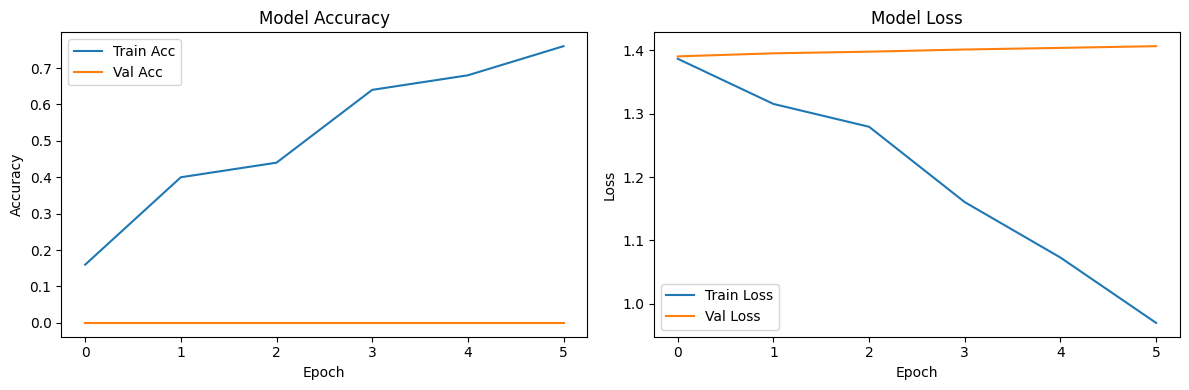

In [10]:
# Plot accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Predict class probabilities
y_pred_probs = cnn_model.predict(X_test)
# Convert one-hot back to class labels
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["rest", "motor", "memory", "math"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()
